In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


In [4]:
# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Resize images to (32, 32) for ResNet compatibility & convert grayscale (1 channel) to RGB (3 channels)
train_images = np.stack([train_images]*3, axis=-1)  # Convert grayscale to 3 channels
test_images = np.stack([test_images]*3, axis=-1)

train_images = tf.image.resize(train_images, (32, 32)) / 255.0
test_images = tf.image.resize(test_images, (32, 32)) / 255.0

# Convert labels to categorical (one-hot encoding)
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Residual Block Function
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # First Convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second Convolution
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add residual connection
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)

    return x

# ResNet-18 Model
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, x)
    return model


In [6]:
# Build the model
resnet18_model = build_resnet18()

# Compile Model
resnet18_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Model
history = resnet18_model.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 75ms/step - accuracy: 0.9266 - loss: 0.2523 - val_accuracy: 0.9696 - val_loss: 0.1094
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 67s 72ms/step - accuracy: 0.9859 - loss: 0.0471 - val_accuracy: 0.9831 - val_loss: 0.0582
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 56s 74ms/step - accuracy: 0.9905 - loss: 0.0316 - val_accuracy: 0.9887 - val_loss: 0.0373
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 75ms/step - accuracy: 0.9908 - loss: 0.0284 - val_accuracy: 0.9876 - val_loss: 0.0449
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 57s 76ms/step - accuracy: 0.9915 - loss: 0.0262 - val_accuracy: 0.9700 - val_loss: 0.1217
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.9928 - loss: 0.0224 - val_accuracy: 0.9843 - val_loss: 0.0641
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 56s 74ms/step - accuracy: 0.9939 - loss: 0.0195 - val_accuracy: 0.9752 - val_loss: 0.0873
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.9942 - loss: 0.0183 - 

313/313 - 3s - 10ms/step - accuracy: 0.9841 - loss: 0.0575
Test Accuracy: 0.9841


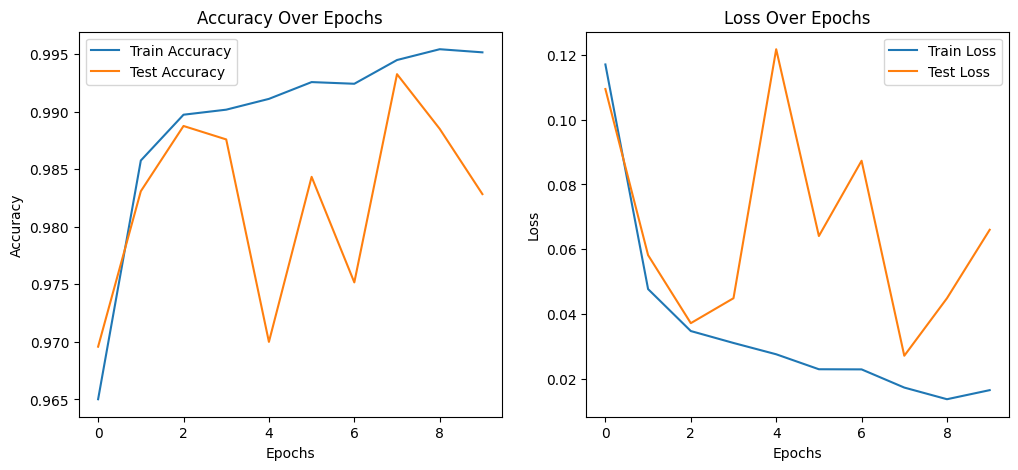

In [8]:
# Evaluate the model
test_loss, test_acc = resnet18_model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()
